# Auto-graded section

Due to the restricted amount of time (Thanksgiving and the end of the semester are coming!), this homework includes a few open-ended questions that will be manually graded by instructors. There will be no more peer reviews!

The block below imports the necessary packages. We have also turned off some "simple" warnings to make things less confusing (you can read more about warning control [here](https://docs.python.org/3/library/warnings.html)).

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import warnings

warnings.simplefilter('ignore')

In this assignment, you will play with the Dow dataset.

In [2]:
df = pd.read_excel('impurity_dataset-training.xlsx')

## 1. ARIMA Model (100 pts)

In this problem, you will construct an ARIMA model of the Dow dataset.

### 1a: Preprocessing (20 pts)

First of all, let's go through the cleaning steps and obtain the time series data from the Dow dataset.

- Extract `Date` and `y:Impurity` columns from `df`.
- Convert the `Date` column to `DateTime` datatype.
- Convert the index of the dataframe to `Date`.

The resulting dataframe should be named `dow_time`.

In [3]:
########################################
# Start your code here
dow_time = df[['Date', 'y:Impurity']]
dow_time.loc[:, 'Date'] = pd.to_datetime(dow_time['Date'])
dow_time = dow_time.set_index('Date')
########################################

In [4]:
assert type(dow_time.index[100]) == pd._libs.tslibs.timestamps.Timestamp
assert dow_time.shape == (10703, 1)
assert np.isclose(dow_time['y:Impurity'].sum(), 29049.039824699998)

### 1b: Moving Average (20 pts)

Compute the moving average `moving_avg` of `dow_time` with a window size of 24 hours.

In [5]:
########################################
# Start your code here
window = 24

rolling_df = dow_time.rolling(window)
moving_avg = rolling_df.mean()
########################################

In [6]:
assert np.isnan(moving_avg.iloc[22].values[0]), "wrong window size"
assert not np.isnan(moving_avg.iloc[23].values[0]), "wrong window size"
assert np.isclose(moving_avg.sum(), 28993.158206), "wrong moving average"

### 1c: Plot moving average (5 pts)

Plot the resulting moving average. The horizontal axis should represent the dates and the vertical axis should represent the moving average.

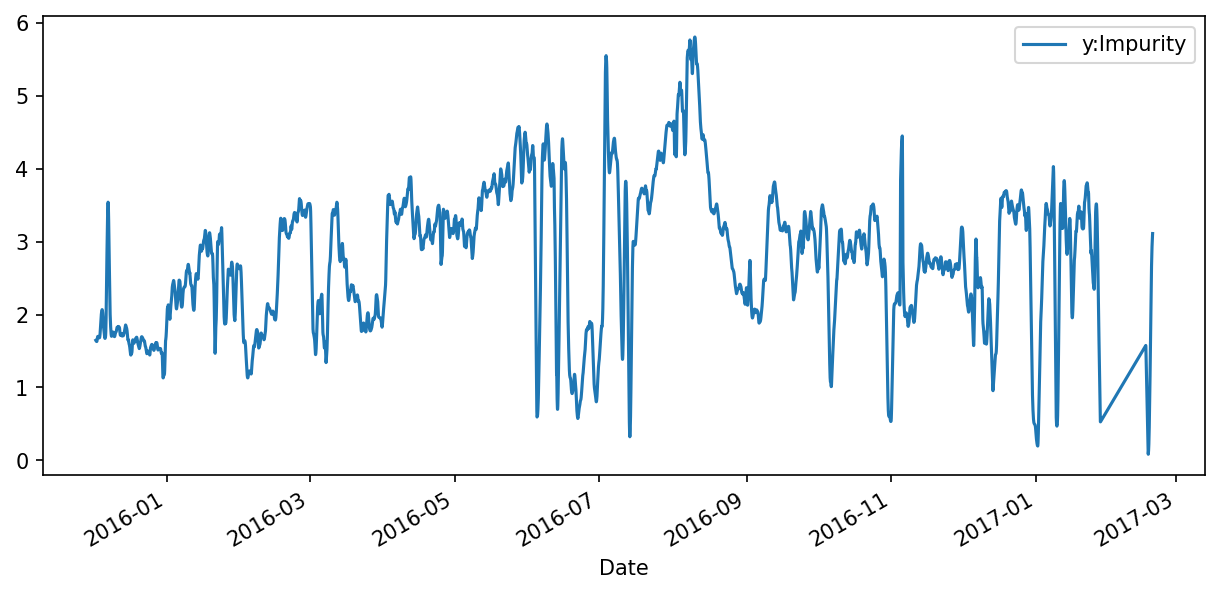

In [7]:
########################################
# Start your code here
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
moving_avg.plot(ax = ax);
########################################

### 1d: Differencing (10 pts)

Apply differencing between a point and the prior point to `dow_time` and save the result to `diff`. By doing so, you can determine `d` of the ARIMA model as 1. `diff` should not contain any null values.

In [8]:
########################################
# Start your code here
diff = dow_time - dow_time.shift(1)
diff = diff[1:]
########################################

In [9]:
from statsmodels.tsa.stattools import adfuller

assert 1 - adfuller(diff)[1]

### 1e: Autocorrelation plot (5 pts)

Show the autocorrelation plot for `diff`.

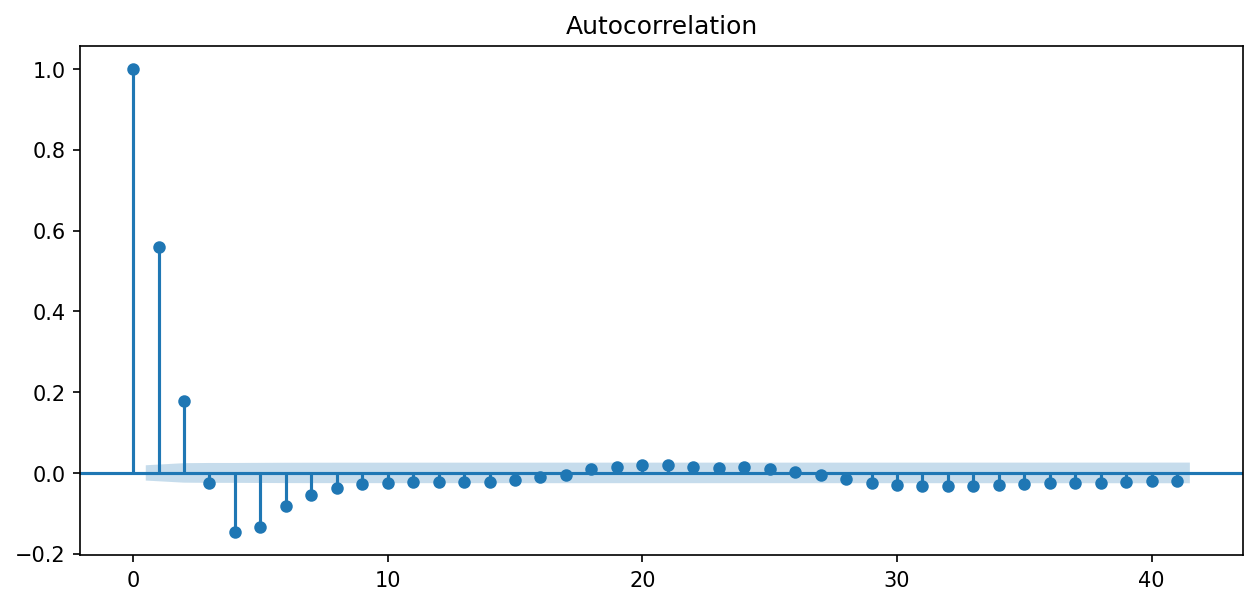

In [10]:
########################################
# Start your code here
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
_ = plot_acf(diff, ax = ax);
########################################

### 1f: Data Split (15 pts)

Split the `y:Impurity` data (not the smoothed version) into a training and test set. The first 75% of the data should be the training set and you will use a forecast to predict the next 25%, so you should not use random selection. Name the training set as `past` and test set as `future`.

In [11]:
########################################
# Start your code here
hours = dow_time.shape[0]

train_ratio = 0.75
N_train = int(train_ratio * hours)
N_test = hours - N_train

past = dow_time[:N_train]
future = dow_time[-N_test:]
########################################

In [12]:
assert past.shape == (8027, 1), "wrong training size"
assert np.isclose(past.mean(), 2.8494), "wrong training set"
assert future.shape == (2676, 1), "wrong test size"
assert np.isclose(future.mean(), 2.30826), "wrong test set"

### 1g: Computing BIC (15 pts)

With all combinations of `d`, `p`, and `q` provided below, train an ARIMA model with `past` and calculate the BIC of the model. Report the optimal `p` and `q` (`p_opt` and `q_opt`) that give the lowest BIC.

- `d`: 1
- `p`: 2, 3, and 4
- `q`: 1 and 2

**Note:** You an safely ignore any "ValueWarnings" that arise due to missing frequency information.

In [13]:
########################################
# Start your code here
from statsmodels.tsa.arima_model import ARIMA

d = 1
bic = 0

for q in [1, 2]:
    for p in [2, 3, 4]:
        model = ARIMA(past, order = (p, d, q))
        model_fit = model.fit(disp = 0)
        if model_fit.bic < bic:
            bic = model_fit.bic
            p_opt = p
            q_opt = q
########################################

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  '

In [14]:
assert np.isclose(ARIMA(past, order = (p_opt, d, q_opt)).fit(disp = 0).bic, -19312.086794490246)

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 1h: Past Prediction (5 pts)

Using the optimal ARIMA model obtained from **1f**, plot the past data along with the past prediction.

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


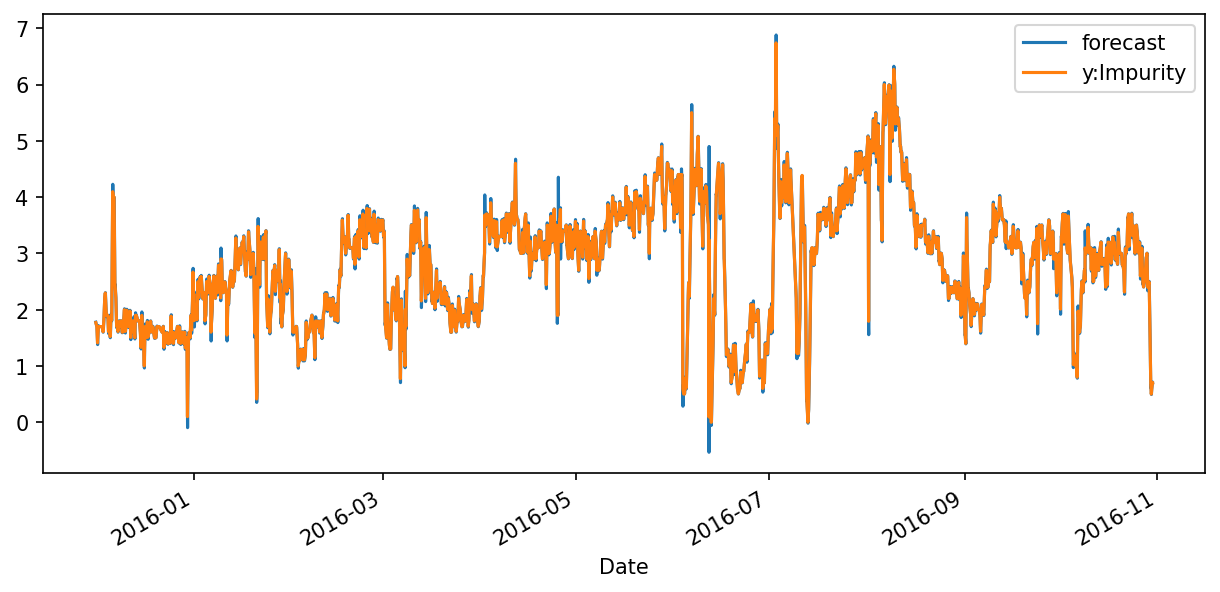

In [15]:
########################################
# Start your code here
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ARIMA(past, order = (p_opt, d, q_opt)).fit(disp = 0).plot_predict(dynamic = False, ax = ax);
########################################

### 1i: Forecast (5 pts)

Plot the forecast of the future data data along with the past, future data, and 95% confidence bounds.

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


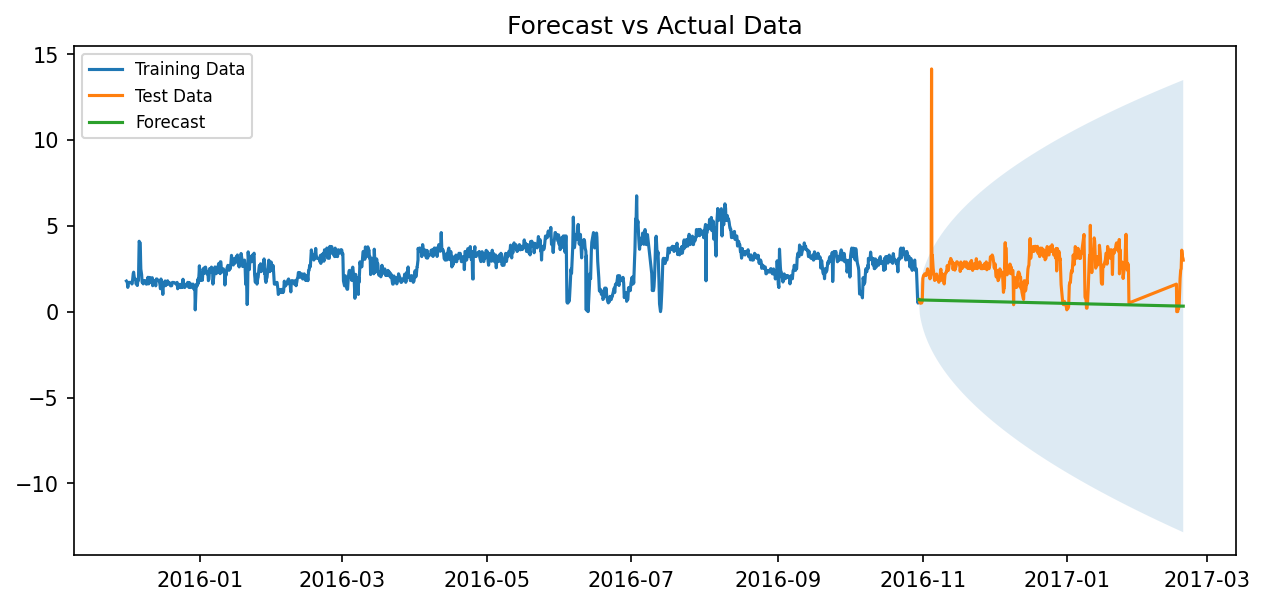

In [16]:
########################################
# Start your code here
fc, se, conf = ARIMA(past, order = (p_opt, d, q_opt)).fit(disp = 0).forecast(N_test, alpha = 0.05)

fc_series = pd.Series(fc, index = future.index)
lower_series = pd.Series(conf[:, 0], index = future.index)
upper_series = pd.Series(conf[:, 1], index = future.index)

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)

ax.plot(past, label = 'Training Data')
ax.plot(future, label = 'Test Data')
ax.plot(fc_series, label = 'Forecast')
ax.fill_between(lower_series.index, lower_series, upper_series, alpha=.15)
ax.set_title('Forecast vs Actual Data')
ax.legend(loc='upper left', fontsize = 8);
########################################